In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
import seaborn as sns
from sklearn.decomposition import PCA
sys.path.append('../')
from utils import *
from processing import *
import cv2 as cv
from image_registration import *
from skimage import color
import scipy as sp

import SimpleITK as sitk
from skimage.transform import rescale,resize
from pystackreg import StackReg
from PIL import Image


          SPIKE
    Version     : 0.99.30
    Date        : 22-03-2022
    Revision Id : 563
*** zoom3D not loaded ***
plugins loaded:
bcorr,  fastclean,  Fitter,  gaussenh,  Linear_prediction,  Peaks,  rem_ridge,  sane,  sg,  test,  urQRd, 

spike.plugins.report() for a short description of each plugins
spike.plugins.report('module_name') for complete documentation on one plugin
plugins loaded:
diagonal_2DMS,  FTMS_calib,  PhaseMS, 


In [3]:
import pickle
with open('../processed_data/Coronal3D_UMAP_datainfo_decoded.pkl', 'rb') as fp:
    UMAP_datainfo = pickle.load(fp)
    
slice_order = ['slide1_2_R00','slide1_2_R01','slide1_2_R02','slide1_2_R03','slide1_2_R04','slide1_2_R05','slide1_2_R06',
              'slide1_2_R07','slide1_2_R08','slide3_5_R00','slide3_5_R10','slide3_5_R01','slide3_5_R02','slide3_5_R03',
              'slide3_5_R04','slide4_6_R00','slide4_6_R11','slide4_6_R01','slide4_6_R02','slide4_6_R03','slide4_6_R04',
              'slide3_5_R05']

# slice_order = ['slide1_2_R00','slide1_2_R01','slide1_2_R02','slide1_2_R03','slide1_2_R04','slide1_2_R05','slide1_2_R06',
#               'slide1_2_R07','slide1_2_R08','slide3_5_R00','slide3_5_R10','slide3_5_R01','slide3_5_R02','slide3_5_R03',
#               'slide3_5_R04','slide4_6_R00','slide4_6_R11','slide4_6_R01','slide4_6_R02','slide4_6_R03','slide4_6_R04',
#               'slide3_5_R05','slide3_5_R06','slide3_5_R07','slide3_5_R08','slide3_5_R11','slide3_5_R09','slide4_6_R05',
#               'slide4_6_R06','slide4_6_R07','slide4_6_R08','slide4_6_R09','slide4_6_R10','slide7_R00','slide7_R01',
#               'slide7_R02','slide7_R03']

# no_transform = ['slide3_4_R01']
# rotate_slice = ['slide1_2_R13','slide1_2_R12','slide1_2_R11','slide1_2_R10','slide1_2_R09','slide1_2_R08','slide1_2_R05','slide1_2_R04','slide1_2_R03']

In [4]:
def pad(img, h, w):
    #  in case when you have odd number
    top_pad = np.floor((h - img.shape[0]) / 2).astype(int)
    bottom_pad = np.ceil((h - img.shape[0]) / 2).astype(int)
    right_pad = np.ceil((w - img.shape[1]) / 2).astype(int)
    left_pad = np.floor((w - img.shape[1]) / 2).astype(int)
    return np.copy(np.pad(img, [(top_pad, bottom_pad), (left_pad, right_pad)], mode='constant'))

In [5]:
import h5py

idx = 0
umap_imgs = []
spec_idx_imgs = []
for slice in slice_order:
    data = UMAP_datainfo[slice_order[idx]]
    coord = data['coordinates']
    embedding = data['embeddings'][:,[1,7,8]]
    umap_img = color.rgb2gray(hyperspectral_vis(embedding,coord,True).transpose(1,0,2))
    umap_img = (umap_img - np.min(umap_img)) / (np.max(umap_img) - np.min(umap_img))
    #umap_img = IonImg(embedding_normal,coord,True,False)
    spec_idx_img = IonImg(np.arange(1,embedding.shape[0]+1),coord,True,False)
    umap_img = pad(umap_img,512,512)
    spec_idx_img = pad(spec_idx_img,512,512)
    # umap_img = np.rot90(umap_img)
    # spec_idx_img = np.rot90(spec_idx_img)
    # if slice in rotate_slice:
    #     umap_imgs_2.append(np.rot90(np.rot90(umap_img)))
    #     umap_img_upsampled = np.rot90(np.rot90(resize(umap_img,(512,1024),order=1)))
    #     spec_idx_img_upsampled = np.rot90(np.rot90(np.array(Image.fromarray(spec_idx_img).resize((umap_img_upsampled.shape[1],umap_img_upsampled.shape[0]), Image.NEAREST))))
    # else:
    #     umap_imgs_2.append(umap_img)
    #     umap_img_upsampled = resize(umap_img,(512,1024),order=1)
    #     spec_idx_img_upsampled = np.array(Image.fromarray(spec_idx_img).resize((umap_img_upsampled.shape[1],umap_img_upsampled.shape[0]), Image.NEAREST))
    #group = hf.create_group(slice)
    umap_imgs.append(umap_img)
    spec_idx_imgs.append(spec_idx_img)
    idx +=1

In [5]:
hf = h5py.File('../image_register/umap_unregistered.h5', 'w')
idx=0
for img in umap_imgs_pad:
    hf.create_dataset(slice_order[idx]+'_msi_img',data=img)
    idx+=1
hf.close()

NameError: name 'umap_imgs_pad' is not defined

In [6]:
import nibabel as nib
file_dir = '../'
epi_labels = nib.load(file_dir+'WHS_SD_rat_atlas_v2.nii.gz')
epi_t2 = nib.load(file_dir+'WHS_SD_rat_T2star_v1.01.nii.gz')
epi_fa = nib.load(file_dir+'WHS_SD_rat_FA_color_v1.01.nii.gz')

In [7]:
epi_labels_data = epi_labels.get_fdata()
epi_t2_data = epi_t2.get_fdata()

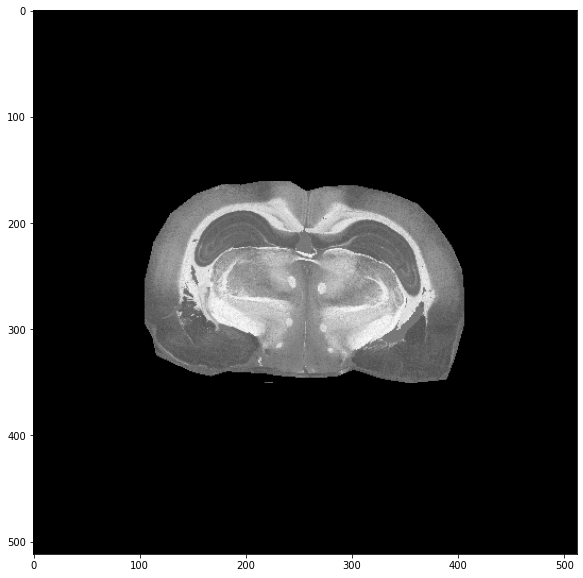

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(umap_imgs[14],'gray')

In [8]:
mri_slice_num = [645,640,635,630,625,613,608,565,561,557,553,549,545,541,536,531,525,520,515,510,505,500,365,360,355,350,330,325,320,310,305,295,290,280,275,270,265]

In [8]:
mri_slice_masked.shape

NameError: name 'mri_slice_masked' is not defined

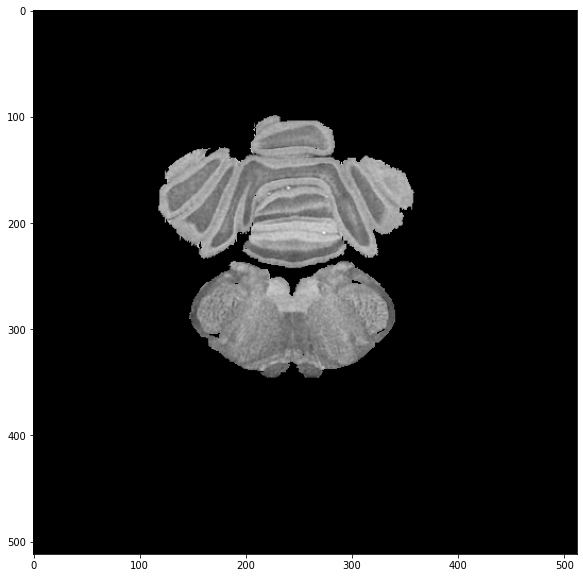

In [11]:
slice_no = 265
label_slice = epi_labels_data[:, slice_no, :].copy()
mri_slice = epi_t2_data[:, slice_no, :].copy()
label_slice_mask = label_slice.copy()
label_slice_mask[label_slice_mask>0] = 1

mri_slice_masked = mri_slice*label_slice_mask
plt.figure(figsize=(10,10))
plt.imshow(np.rot90(mri_slice_masked),'gray')

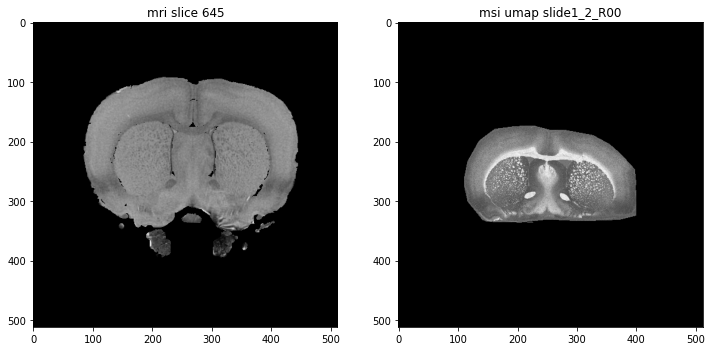

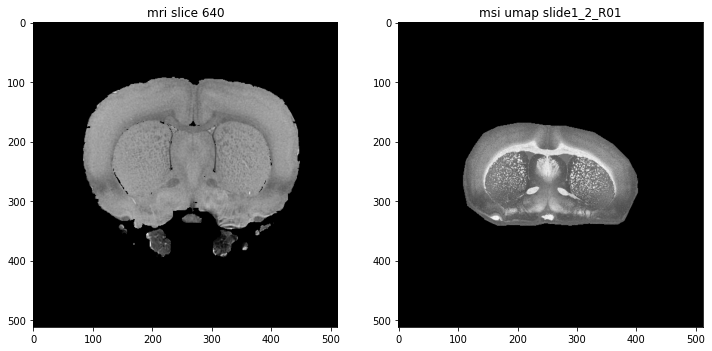

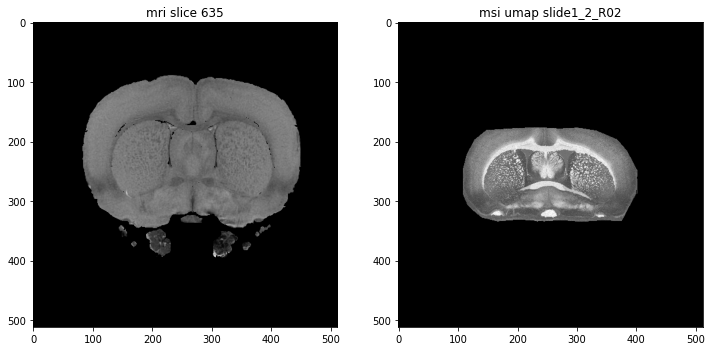

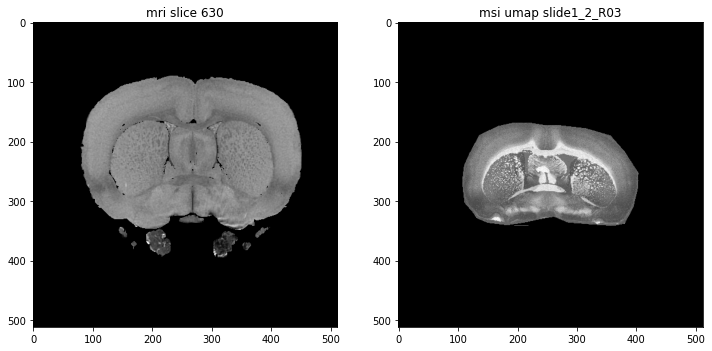

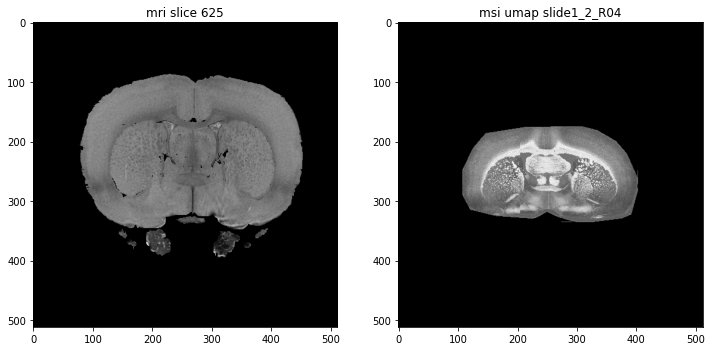

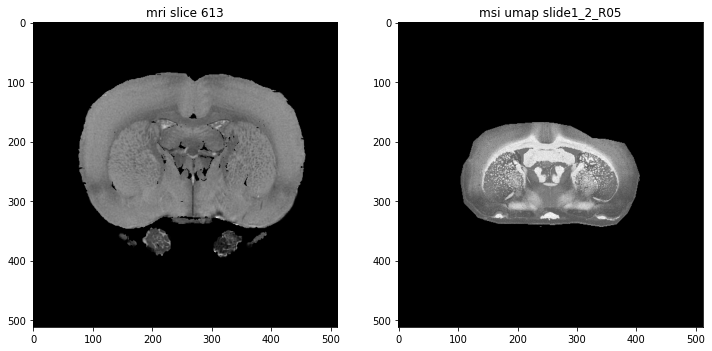

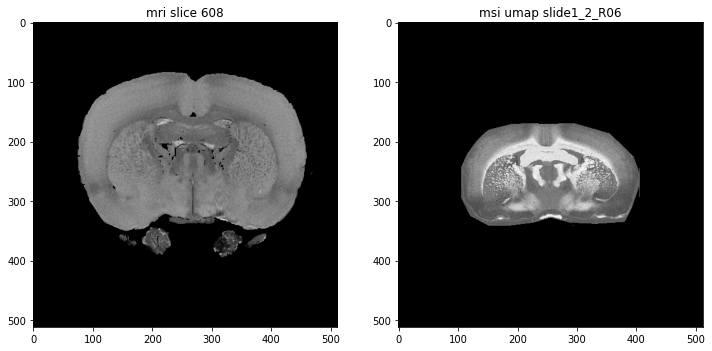

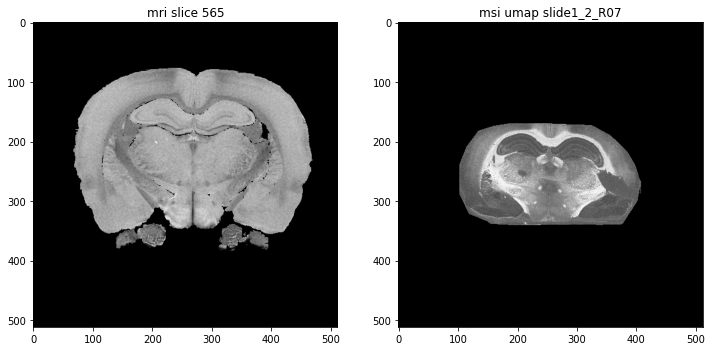

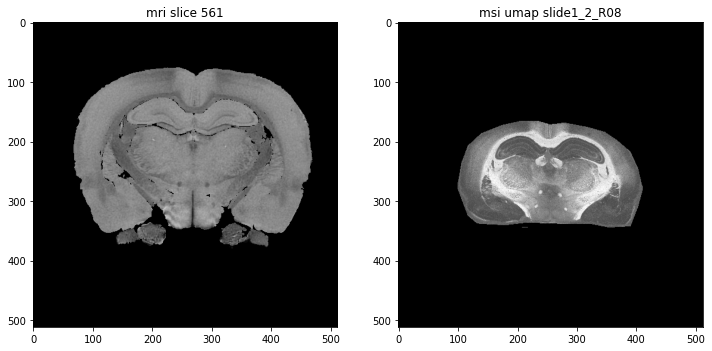

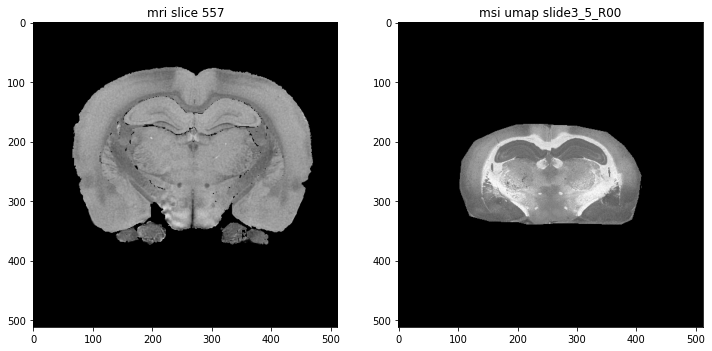

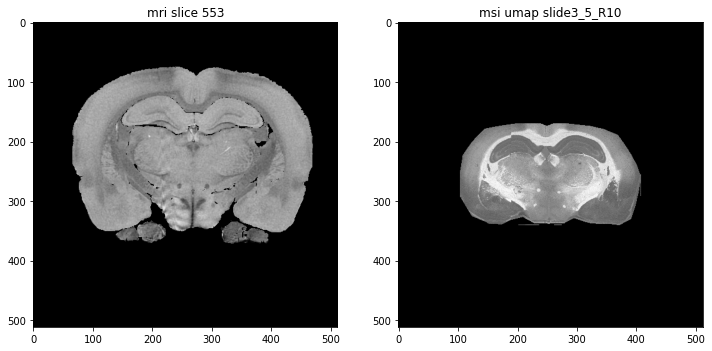

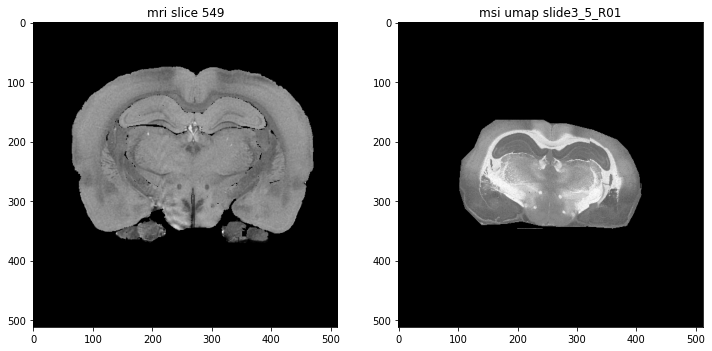

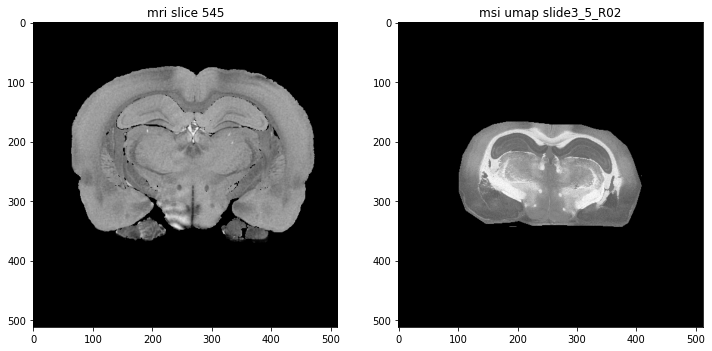

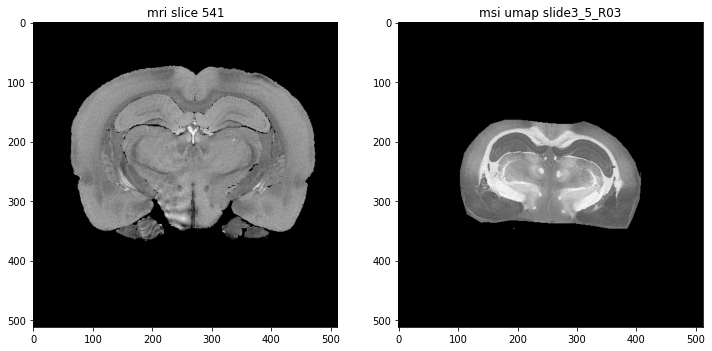

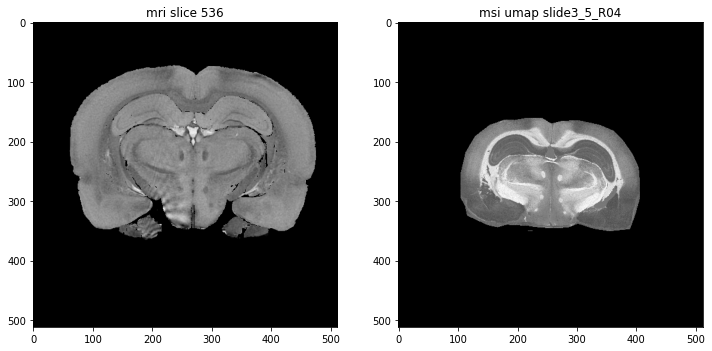

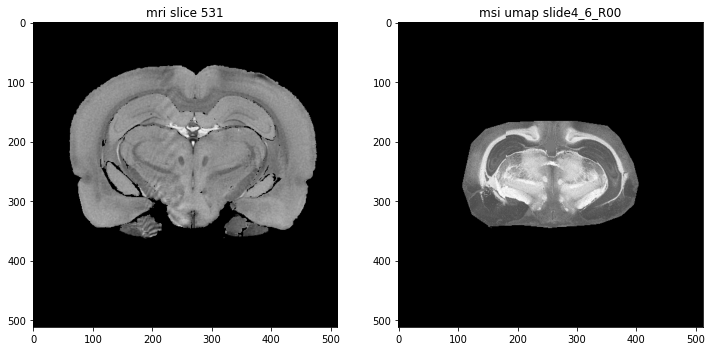

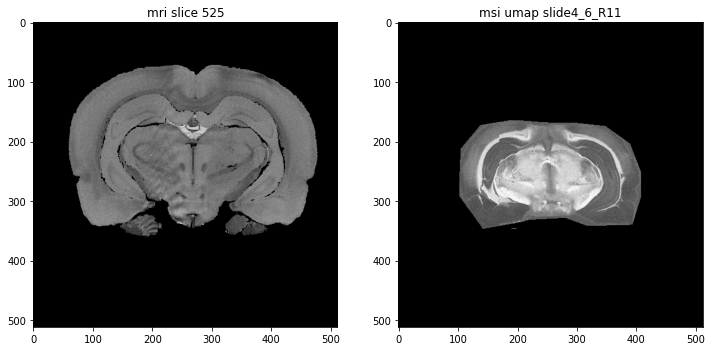

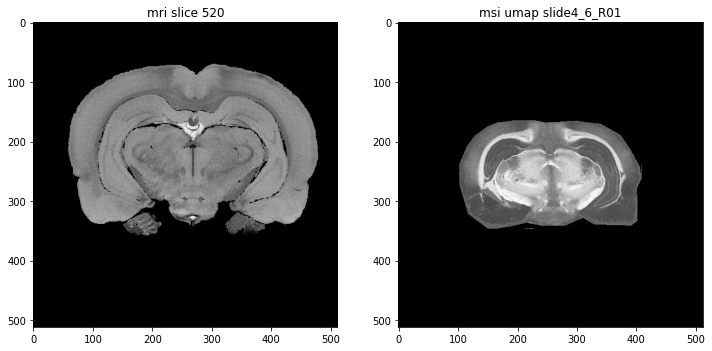

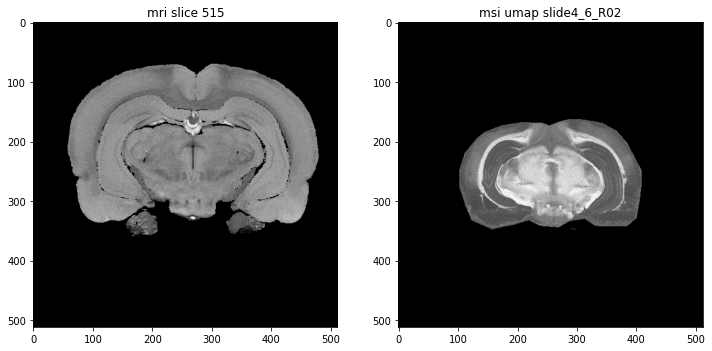

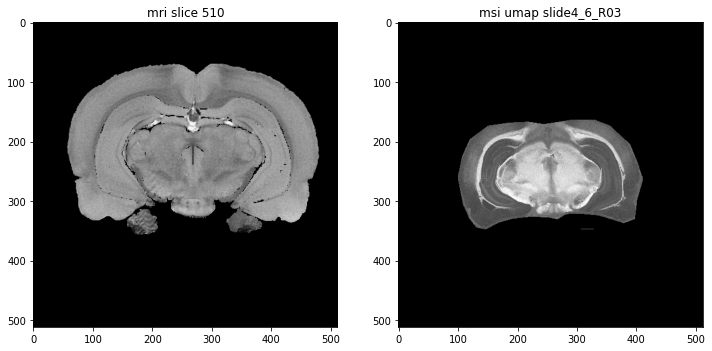

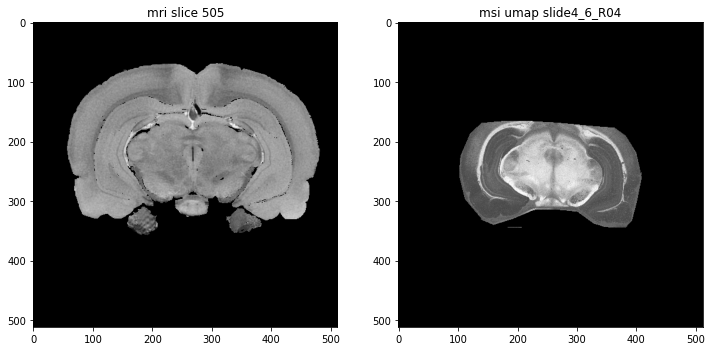

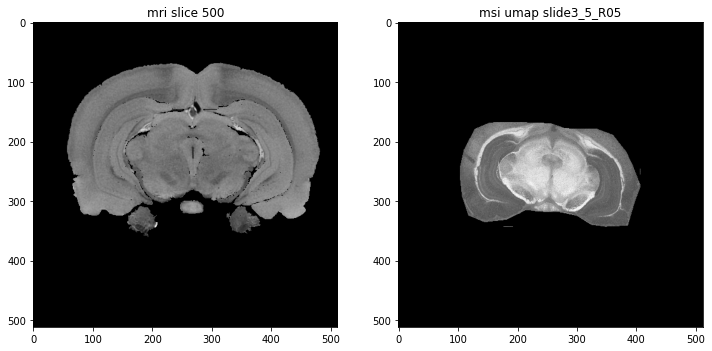

In [9]:
#mri_slice_num = [645,640,635,630,625,613,608,565,561,557,553,549,545,541,536,531,525,520,515,510,505,500,365,360,355,350,330,325,320,310,305,295,290,280,275,270,265]
mri_slice_num = [645,640,635,630,625,613,608,565,561,557,553,549,545,541,536,531,525,520,515,510,505,500]

mri_imgs = []
label_imgs = []
for i in range(len(mri_slice_num)):
    slice_no = mri_slice_num[i]

    label_slice = epi_labels_data[:, slice_no, :].copy()
    mri_slice = epi_t2_data[:, slice_no, :].copy()
    label_slice_mask = label_slice.copy()
    label_slice_mask[label_slice_mask>0] = 1

    mri_slice_masked = mri_slice*label_slice_mask
    #mri_slice_masked = (mri_slice_masked - np.min(mri_slice_masked)) / (np.max(mri_slice_masked) - np.min(mri_slice_masked))
    mri_slice_masked = mri_slice_masked/mri_slice_masked.max()
    #mri_slice_masked[label_slice_mask==0]+=1
    mri_slice_masked = np.flip(mri_slice_masked.T)
    mri_slice_label = np.flip(label_slice.T)

    mri_imgs.append(mri_slice_masked)
    label_imgs.append(mri_slice_label)
    
    fig,axes = plt.subplots(1,2,figsize=(12,6))
    ax = axes.ravel()
    ax[0].set_title('mri slice {}'.format(slice_no))
    ax[1].set_title('msi umap {}'.format(slice_order[i]))
    ax[0].imshow(mri_slice_masked,'gray')
    ax[1].imshow(umap_imgs[i],'gray')
    plt.show()

In [10]:
def save_msi_transform_stack(file_name,img_stack):
    upsampled_imgs = []
    hf = h5py.File(file_name, 'w')
    idx = 0
    for slice in slice_order:
        img = np.rot90(img_stack[idx])
        if slice in rotate_slice:
            img_upsampled = np.rot90(np.rot90(resize(img,(512,1024),order=1)))
        else:
            img_upsampled = resize(img,(512,1024),order=1)
        upsampled_imgs.append(img_upsampled)
        hf.create_dataset(slice+'_msi_img',data=img_upsampled)
        idx+=1
    hf.close()
    return upsampled_imgs

In [601]:
# cv.imwrite('../mri_img.tiff',mri_slice_masked)
import h5py

hf = h5py.File('../image_register/coronal3D_image_reg.h5', 'w')
idx = 0
for slice in slice_order:
    hf.create_dataset(slice+'_umap_img',data=umap_imgs[idx])
    hf.create_dataset(slice+'_spec_idx_img',data=spec_idx_imgs[idx])
    hf.create_dataset(slice+'_mri_img',data=mri_imgs[idx])
    idx+=1
hf.close()

In [8]:
# from scipy.io import loadmat
# spec_idx_transformed = loadmat('../image_register/spec_idx_imgs_transformed.mat')['spec_idx_imgs_transformed']
# msi_imgs_transformed = loadmat('../image_register/msi_imgs_transformed.mat')['msi_imgs_transformed']

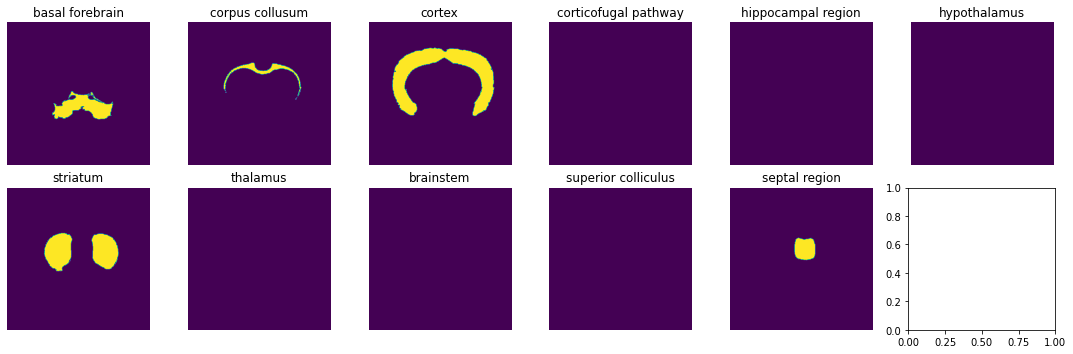

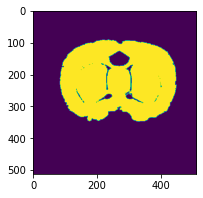

In [11]:
atlas_region = {'basal forebrain':82,'corpus collusum':67,'cortex':92,'corticofugal pathway':1,'hippocampal region':[95,96,97,98],'hypothalamus':48,'striatum':30,
                'thalamus':39,'brainstem':47,'superior colliculus':[50,55],'septal region':40}
slice_no = 1
fig,axes = plt.subplots(2,6,figsize=(15,5))
ax = axes.ravel()
idx = 0
for key in atlas_region.keys():
    ax[idx].imshow((np.isin(label_imgs[slice_no], atlas_region[key])))
    ax[idx].axis('off')
    ax[idx].set_title(key)
    idx+=1
fig.tight_layout()
fig,axes = plt.subplots(1,1,figsize=(3,3))
axes.imshow((np.isin(label_imgs[slice_no], [92,30,67,39,1,95,96,97,98,48,82,47,50,55,40])))

In [12]:
import image_registration
#file_dir = '../processed_data/coronal3D_propagated_decoded.h5'
file_dir = 'E:/3DCoronal/decoded_data_new/coronal3D_propagated_decoded_new.h5'
reg = image_registration.Image(data_dir=file_dir,registration_dir='../image_transform',group_order=slice_order)
reg.load_transform('../image_register/Matlab Registration/coronal_registration')
reg.load_data(True)

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:55<00:00,  5.24s/it]


In [23]:
slice_order[-5]

'slide3_5_R05'

In [13]:
cere_data = []
cere_regions = []
cere_slices = []
for slice in slice_order[-4:]:
    cere_data.append(reg.data[slice]['intens_mtx'])
    cere_regions+=['cerebellum']*len(reg.data[slice]['intens_mtx'])
    cere_slices+=[slice]*len(reg.data[slice]['intens_mtx'])

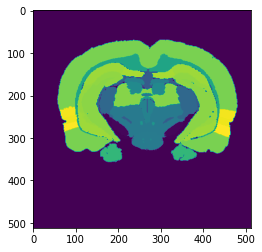

In [41]:
plt.imshow(label_imgs[idx])


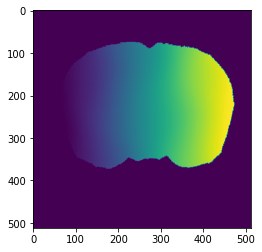

In [45]:
plt.imshow(reg.transform[slice_order[10]].T)

In [ ]:
sorted(list(set(reg.transform['slide1_2_R00'].T[np.isin(label_imgs[slice_no],atlas_region[key])].astype(int)-1)))

In [16]:
spec_region = {}
idx = 0
mz = reg.mzs
mz_filter = (mz>600)&(mz<1200)
slice_order_use = slice_order.copy()
#data_arr = []
regions_all = []
slices_all = []
for slice in slice_order_use:
    data = {}
    regions = []
    
    for key in atlas_region.keys():
        region_idx = np.array(sorted(list(set(reg.transform[slice].T[np.isin(label_imgs[idx],atlas_region[key])].astype(int)-1))))
        region_data = reg.data[slice]['intens_mtx'][list(region_idx[region_idx>=0])]
        data[key] = region_data
        #data_arr.append(region_data)
        regions+=[key]*region_data.shape[0]
        slices_all+=[slice]*region_data.shape[0]
    idx +=1
    spec_region[slice] = data
    regions_all+=regions
    #spec_region[slice]['region'] = regions

In [32]:
metadata = pd.DataFrame({'regions':regions_all+cere_regions,'slice':slices_all+cere_slices})

In [33]:
metadata

,regions,slice
0,basal forebrain,slide1_2_R00
1,basal forebrain,slide1_2_R00
2,basal forebrain,slide1_2_R00
3,basal forebrain,slide1_2_R00
4,basal forebrain,slide1_2_R00
...,...,...
941992,cerebellum,slide4_6_R08
941993,cerebellum,slide4_6_R08
941994,cerebellum,slide4_6_R08
941995,cerebellum,slide4_6_R08


In [34]:
data_df = pd.DataFrame(np.concatenate([np.concatenate(data_arr),np.concatenate(cere_data)]),columns=reg.mzs)
import random
random.seed(19)
rows_id = random.sample(range(0, data_df.shape[0]), int(data_df.shape[0]*0.2))

In [35]:
data_df

,400.278496,400.285701,400.340944,402.021083,403.255567,404.292455,405.300395,406.279156,406.296220,407.957290,...,1065.425584,1065.540656,1067.697353,1080.437754,1081.397606,1085.447423,1086.450837,1088.453917,1088.767436,1097.418101
0,0.001286,0.001035,0.000022,0.000111,0.000235,0.000099,0.000380,0.000067,0.000017,0.000066,...,0.000110,0.000054,0.000055,0.000054,0.000160,0.000018,0.000028,0.000068,0.000065,0.000077
1,0.001256,0.000987,0.000021,0.000125,0.000238,0.000097,0.000363,0.000055,0.000016,0.000114,...,0.000094,0.000054,0.000046,0.000098,0.000133,0.000002,0.000025,0.000058,0.000052,0.000074
2,0.001175,0.000941,0.000022,0.000144,0.000225,0.000116,0.000328,0.000069,0.000019,0.000106,...,0.000089,0.000066,0.000043,0.000069,0.000143,0.000006,0.000034,0.000076,0.000065,0.000095
3,0.001151,0.000922,0.000006,0.000091,0.000236,0.000092,0.000428,0.000042,0.000023,0.000064,...,0.000087,0.000037,0.000056,0.000040,0.000114,0.000024,0.000030,0.000078,0.000097,0.000064
4,0.000948,0.000694,0.000050,0.000038,0.000156,0.000148,0.000624,0.000024,0.000012,0.000135,...,0.000069,0.000031,0.000080,0.000025,0.000064,0.000036,0.000058,0.000075,0.000154,0.000072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941992,0.001281,0.000944,0.000008,0.000047,0.000249,0.000134,0.000428,0.000045,0.000046,0.000080,...,0.000072,0.000011,0.000067,0.000058,0.000036,0.000026,0.000030,0.000089,0.000074,0.000064
941993,0.001256,0.000970,0.000003,0.000022,0.000186,0.000118,0.000508,0.000042,0.000013,0.000034,...,0.000068,0.000071,0.000096,0.000022,0.000058,0.000048,0.000024,0.000076,0.000077,0.000036
941994,0.000211,0.000029,0.000042,0.000252,0.000111,0.000288,0.000379,0.000103,0.000206,0.000367,...,0.000106,0.000121,0.000117,0.000312,0.000262,0.000134,0.000076,0.000197,0.000204,0.000016
941995,0.000307,0.000065,0.000080,0.000353,0.000212,0.000266,0.000375,0.000073,0.000080,0.000281,...,0.000089,0.000092,0.000009,0.000309,0.000086,0.000181,0.000176,0.000232,0.000197,0.000176


In [7]:
# data_df.to_pickle('F:/coronal3D_regional_pixel.pkl')
# metadata.to_pickle('F:/coronal3D_regional_pixel_metadata.pkl')
data_df = pd.read_pickle('F:/coronal3D_regional_pixel.pkl')
metadata = pd.read_pickle('F:/coronal3D_regional_pixel_metadata.pkl')

In [ ]:
import umap
UMAP = umap.UMAP(n_neighbors=30,min_dist=0.5).fit_transform(data_df)

In [26]:
region_data = scMSAnalysis(metadata.iloc[rows_id])
region_data.preprocessing(data_df.iloc[rows_id]
                          ,norm_method='None',feat_drop_rate=0.001,cell_drop_rate=0.01)

filtered intensity matrix with shape (161906, 1156)


c:\users\richard\appdata\local\programs\python\python38\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [27]:
region_data.get_labels(['regions'])
region_data.analyze(n_neighbors=30, n_pcs=50, min_dist=0.5, resolution = 0.15,
              categories=['types'])

computing neighbors..


AttributeError: 'NNDescent' object has no attribute 'neighbor_graph'

In [ ]:
import pynndescent

In [15]:
data = spec_region[slice_order_use[11]]
data_spec = np.concatenate([data[key] for key in data.keys()])
data_label = np.concatenate([[key]*data[key].shape[0] for key in data.keys()])

In [22]:
np.where(mz[mz_filter]==772.528340255557)
np.where(mz[mz_filter]==826.5743945846459)

(array([243], dtype=int64),)

In [37]:
reg.data[slice_order_use[15]]['intens_mtx'].shape

(66304, 1609)

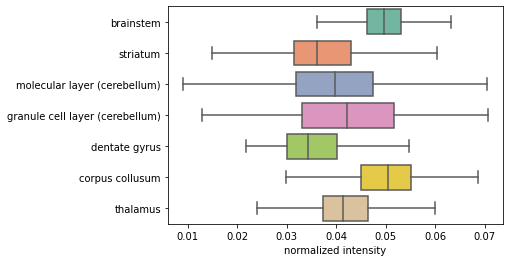

In [54]:
plt.figure(figsize=(6,4))
sns.boxplot(x=data_spec[:,243],y=data_label,palette='Set2',showfliers=False)
plt.xlabel('normalized intensity')
plt.savefig('../figures/distribution.pdf')

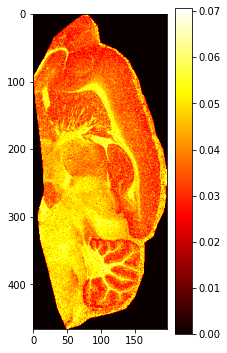

In [53]:
plt.figure(figsize=(3,6))
plt.imshow(IonImg(reg.data[slice_order_use[11]]['intens_mtx'][:,mz_filter][:,243],reg.data[slice_order_use[11]]['coordinates'],True,False),'hot')
plt.colorbar()
plt.savefig('../figures/ion_img.tiff')

In [17]:
average_spec_region = []
regions = []
slices = []
average_spec_label = []
average_spec_label_onehot = []
for slice in slice_order:
    label_idx = 0
    for key in atlas_region.keys():
        label_onehot = np.array([0,0,0,0,0,0,0,0,0,0,0])
        if spec_region[slice][key].shape[0] != 0:
            spec = spec_region[slice][key].mean(0)
            average_spec_region.append(spec)
            slices.append(slice)
            regions.append(key)
            average_spec_label.append(label_idx)
            label_onehot[label_idx] = 1
            average_spec_label_onehot.append(label_onehot)
        label_idx+=1
average_spec_region = np.array(average_spec_region)
average_spec_label_onehot = np.array(average_spec_label_onehot)

In [18]:
from scipy.stats import ranksums

regional_average = {}
regional_pval = {}

for region in atlas_region.keys():
    regional_average[region] = average_spec_region[np.in1d(regions,region)].mean(0)
    regional_pval[region] = [-np.log10(ranksums(average_spec_region[np.in1d(regions,region)][:,i],
                    average_spec_region[np.in1d(regions,region,invert=True)][:,i])[1]) for i in range(average_spec_region.shape[1])]
regional_average = pd.DataFrame(regional_average)
regional_pval = pd.DataFrame(regional_pval)

In [21]:
regional_change = {}

for region in atlas_region.keys():
    regional_change[region] = np.log2(regional_average[region]/regional_average.drop(region,axis=1).mean(1))
regional_change = pd.DataFrame(regional_change)

In [25]:
regional_average.index = reg.mzs
regional_change.index = reg.mzs

In [26]:
regional_change.to_pickle('coronal3d_regional_fc_shared.pkl')
regional_average.to_pickle('coronal3d_regional_avg_shared.pkl')

In [13]:
metadata_average_spec_region = pd.DataFrame({'regions':regions,'slices':slices})

NameError: name 'regions' is not defined

In [33]:
average_spec_region = pd.DataFrame(average_spec_region)

average_spec_region.to_pickle('E:/average_spec_region.pkl')
metadata_average_spec_region.to_pickle('E:/metadata_average_spec_region.pkl')

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca = pca.fit(average_spec_region)

pca_scores = pca.fit_transform(average_spec_region)
UMAP = umap.UMAP(n_neighbors=25,min_dist=0.5).fit_transform(average_spec_region)

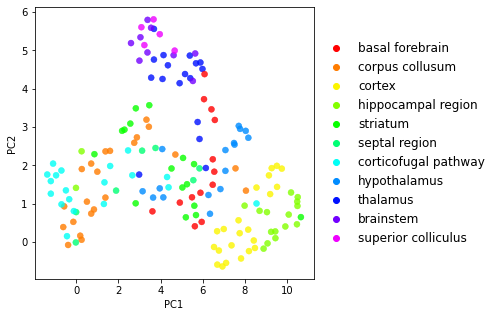

In [202]:
import matplotlib
cmap = matplotlib.cm.get_cmap('hsv')
norm = matplotlib.colors.Normalize(vmin=0.0, vmax=12.0)
colors = [cmap(norm(i)) for i in range(0,11)]

pca_avg_spec_df = pd.DataFrame({'PC1':UMAP[:,0],'PC2':UMAP[:,1],'regions':regions,'slices':slices})
plt.figure(figsize=(5,5))
#plt.ylim([-0.03,0.04])
# plt.xlim([-50,50])
region_show = atlas_region.keys()
#region_show = ['molecular layer cerebellum','granule cell layer cerebellum']
sns.scatterplot(x='PC1',y='PC2',hue='regions',data=pca_avg_spec_df[pca_avg_spec_df['regions'].isin(region_show)],palette=colors,alpha=0.8,edgecolor=None)
plt.legend(frameon=False,fontsize=12,ncol=1,loc='center left',bbox_to_anchor=(1, 0.5))
plt.savefig('../figures/3d_coronal_avg_spec_umap.pdf')

In [35]:
# plt.figure(figsize=(5,5))
# # plt.ylim([-10,12])
# # plt.xlim([-50,50])
# #1gm 6wm
# colors = [cmap(norm(1)),cmap(norm(1)),cmap(norm(6)),cmap(norm(1)),cmap(norm(6)),cmap(norm(1)),cmap(norm(6))]
# sns.scatterplot(x='PC1',y='PC2',hue='regions',data=pca_avg_spec_df,alpha=0.8,edgecolor='black',legend=False)

In [50]:
# plt.figure(figsize=(10,5))
# plt.stem(mz[mz_filter],pca.components_[0],markerfmt=' ',basefmt='black',linefmt='slategray',label='PC1 components')
# plt.stem(mz[mz_filter],pca.components_[1],markerfmt=' ',basefmt='black',linefmt='salmon',label='PC1 components')
# plt.legend()
# plt.xlabel('m/z')

In [33]:
from sklearn.cross_decomposition import PLSRegression
slice_num = 29
data_train = []
label = []
data_label = []
label_idx = 0
for key in atlas_region.keys():
    dummy_label = np.array([0,0,0,0,0,0,0])
    data_train.append(spec_region[slice_order[slice_num]][key])
    label.append([key]*spec_region[slice_order[slice_num]][key].shape[0])
    #dummy_label[label_idx] = 1
    data_label.append([label_idx]*spec_region[slice_order[slice_num]][key].shape[0])
    label_idx +=1
data_train = np.concatenate(data_train)
data_label = np.concatenate(data_label)
label = np.concatenate(label)

In [34]:
import xgboost
model = xgboost.XGBClassifier(n_estimators=100,random_state=19,n_jobs=8)
model.fit(average_spec_region,average_spec_label)

c:\users\richard\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:07:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=19, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Confusion matrix, without normalization
[[13  0  0  0  0  0  0  0  0  0  0]
 [ 0 22  0  0  0  0  0  0  0  0  0]
 [ 0  0 22  0  0  0  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  0  0  0  0  0]
 [ 0  0  0  0  0 16  0  0  0  0  0]
 [ 0  0  0  0  0  0 16  0  0  0  0]
 [ 0  0  0  0  0  0  0 17  0  0  0]
 [ 0  0  0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  0  0  0  7]]


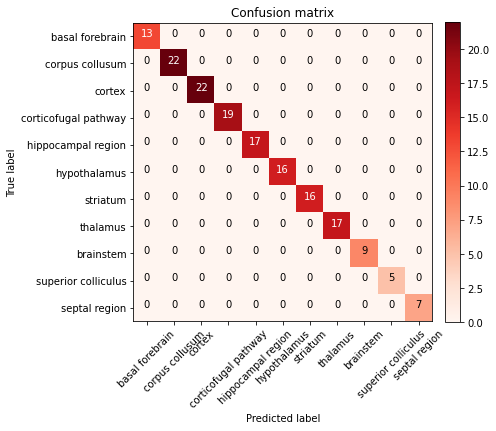

In [35]:
from sklearn.metrics import classification_report, confusion_matrix,multilabel_confusion_matrix

pred = model.predict(average_spec_region)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.figure(figsize=(7,7))
    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(im,fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('../figures/regional_confusion_mtx.pdf')
    
cf_matrix = confusion_matrix(average_spec_label,pred)

plot_confusion_matrix(cf_matrix, classes=atlas_region.keys())

<StemContainer object of 3 artists>

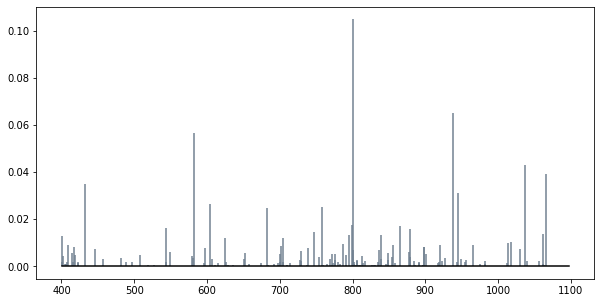

In [36]:
plt.figure(figsize=(10,5))
feature_rank = np.argsort(model.feature_importances_)[::-1]
plt.stem(mz,model.feature_importances_,markerfmt=' ',basefmt='black',linefmt='slategray',label='PC1 components')

In [43]:
# plsr = PLSRegression(n_components=30, scale=False)
# plsr.fit(average_spec_region, average_spec_label_onehot)

In [44]:
# plt.figure(figsize=(5,5))
# plsr_df = pd.DataFrame({'w1':plsr.x_scores_[:,0],'w2':plsr.x_scores_[:,1],'region':regions})
# colors = [cmap(norm(i)) for i in range(1,8)]
# sns.scatterplot(x='w1',y='w2',hue='region',data=plsr_df,alpha=0.7,palette=colors,edgecolor='black')
# plt.legend(frameon=False,fontsize=12,ncol=1,loc='center left',bbox_to_anchor=(1, 0.5))


In [45]:
# plt.figure(figsize=(5,5))
# plsr_df = pd.DataFrame({'w1':plsr.x_scores_[:,0],'w2':plsr.x_scores_[:,1],'region':regions})
# colors = [cmap(norm(1)),cmap(norm(1)),cmap(norm(6)),cmap(norm(1)),cmap(norm(6)),cmap(norm(1)),cmap(norm(6))]
# sns.scatterplot(x='w1',y='w2',hue='region',data=plsr_df,alpha=0.7,palette=colors,edgecolor='black')
# plt.legend(frameon=False,fontsize=12,ncol=1,loc='center left',bbox_to_anchor=(1, 0.5))

In [37]:
plt.figure(figsize=(10,5))
plt.stem(mz[mz_filter],plsr.x_loadings_[:,0],markerfmt=' ',basefmt='black',linefmt='slategray',label='PC1 components')
plt.stem(mz[mz_filter],plsr.x_loadings_[:,1],markerfmt=' ',basefmt='black',linefmt='salmon',label='PC1 components')
plt.legend()
plt.xlabel('m/z')

NameError: name 'plsr' is not defined

<Figure size 720x360 with 0 Axes>

In [38]:
variance_in_x = np.var(plsr.x_scores_, axis = 0) 
total_variance_in_x = np.var(average_spec_region, axis = 0).sum()
fractions_of_explained_variance = variance_in_x / total_variance_in_x

NameError: name 'plsr' is not defined

In [45]:
weights = abs(plsr.x_weights_)@fractions_of_explained_variance
feature_rank = np.argsort(weights)[::-1]

In [46]:
# colors = [cmap(norm(i)) for i in range(1,8)]
# sns.boxplot(x=regions,y=average_spec_region[:,feature_rank_plsr[i]],showfliers=False,palette=colors,hue=regions)
# plt.legend(frameon=False,fontsize=12,ncol=1,loc='center left',bbox_to_anchor=(1, 0.5))

In [39]:
reg.IonImg_transform(reg.data[slice_order_use[19]]['intens_mtx'][:,feature_rank[i]],
                           reg.transform[slice_order_use[19]],True)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
colors = [cmap(norm(i)) for i in range(0,11)]

for i in [0,3,8]:
    print(i)
    fig,axes = plt.subplots(1,2,figsize=(10,4))
    ax = axes.ravel()
    sns.barplot(x=regions,y=average_spec_region[:,feature_rank[i]],ax=ax[0],palette=colors)
    #sns.stripplot(x=regions,y=average_spec_region[:,feature_rank[i]],ax=ax[0],color='.3',size=4)
    ax[0].tick_params(axis='x', labelrotation= 90)
    ax[1].imshow(reg.IonImg_transform(reg.data[slice_order_use[9]]['intens_mtx'][:,feature_rank[i]],
                           reg.transform[slice_order_use[9]],True).T,'hot')
    print('m/z {}'.format(mz[feature_rank[i]]))
    fig.savefig('../figures/coronal_regional_{}.pdf'.format(i))

NameError: name 'cmap' is not defined

In [72]:
with open('../Coronal3D_annotation_decoded.pkl', 'rb') as fp:
    annot_df = pickle.load(fp)

In [119]:
annot_df[annot_df['index']==feature_rank[0]]

,Input m/z,Matched m/z,Delta,Name,Formula,Ion,ppm,index
3793,919.749964,919.7514,0.0014,PA O-53:5,C56H104O7P,[M+H]+,1.522153,154
3794,919.749964,919.7474,0.0026,EPC 49:1;O5,C51H104N2O9P,[M+H]+,2.826855,154
3795,919.749964,919.7474,0.0026,SM 46:1;O5,C51H104N2O9P,[M+H]+,2.826855,154
3796,919.749964,919.7538,0.0038,DG O-60:14,C63H99O4,[M+H]+,4.131558,154
3797,919.749964,919.7490,0.0010,PA O-51:2,C54H105O7PNa,[M+Na]+,1.087252,154
3798,919.749964,919.7514,0.0014,CE 34:6;O2,C61H100O4Na,[M+Na]+,1.522153,154
3799,919.749964,919.7514,0.0014,DG O-58:11,C61H100O4Na,[M+Na]+,1.522153,154
3800,919.749964,919.7515,0.0016,CE 31:1;O3,C58H104O5K,[M+K]+,1.739603,154
3801,919.749964,919.7515,0.0016,DG 55:5,C58H104O5K,[M+K]+,1.739603,154
3802,919.749964,919.7515,0.0016,DG O-55:6;O,C58H104O5K,[M+K]+,1.739603,154


In [108]:
img_set = reg.get_3DImages_transform(456,True)

In [157]:
from skimage import img_as_ubyte
from tifffile import imsave

def save_tiff_stack(imgs,file_name):
    img_stack = (np.stack(imgs))
    #img_stack = img_stack/img_stack.max()
    imsave(file_name, img_stack)
    return img_stack

#img_stack = save_tiff_stack(img_set,'../image_register/coronal_456mzidx.tif')

In [178]:
for key in atlas_region.keys():
    print(key)

basal forebrain
corpus collusum
cortex
corticofugal pathway
hippocampal region
hypothalamus
striatum
thalamus
brainstem
superior colliculus
septal region


In [41]:
mri_label_imgs = np.swapaxes(epi_labels_data[:,500:645,:].copy(),0,1)
mri_label_imgs_use = np.empty(mri_label_imgs.shape)
mri_label_imgs_use[:] = np.nan
idx = 0
for key in atlas_region.keys():
    mri_label_imgs_use[np.isin(mri_label_imgs, atlas_region[key])] = idx
    #mri_label_imgs_use[np.isin(mri_label_imgs, atlas_region[key])] = average_spec_region[np.where(np.array(regions)==key),feature_rank[8]].mean()
    idx += 1

In [239]:
mz

array([1099.49614656, 1097.42221846, 1088.76951838, ...,  206.05600997,
        177.01631856,  176.00867948])

In [175]:
img_stack = save_tiff_stack(mri_label_imgs_use,'../image_register/mri_label_spec_avg_intens_8.tif')

In [254]:
average_spec_region.mean(0).shape

(1, 1096)

KeyError: ((array([ 0,  6, 11, 16, 23, 29, 37, 45, 53, 61, 69, 77, 85], dtype=int64),), slice(None, None, None))

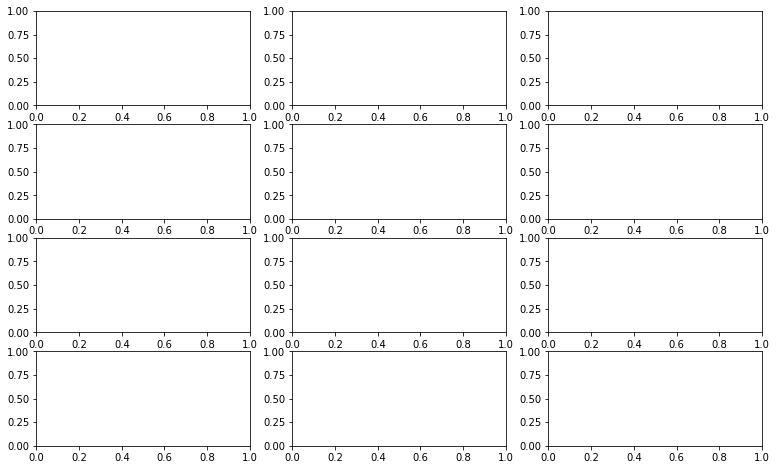

<Figure size 216x108 with 0 Axes>

In [42]:
mz_filter = (mz<900)&(mz>680)
idx=0
plt.rcParams["axes.grid"] = False
fig,axes = plt.subplots(4,3,figsize=(13,8))
ax = axes.ravel()
for key in atlas_region.keys():
    plt.figure(figsize=(3,1.5))
    #for i in range(mz[mz_filter].size):
    avg_spec = average_spec_region[np.where(np.array(regions)==key),:].mean(1)[0][mz_filter]
    diff_spec = (average_spec_region.mean(0)[mz_filter]-avg_spec)
    ax[idx].plot(mz[mz_filter],diff_spec,c='k',alpha=1,linewidth=1)
    ax[idx].set_title(key)
    idx+=1
fig.tight_layout()
fig.savefig('../figures/coronal_regional_spec_diff.pdf')

In [43]:
import scanpy as sc
import anndata

In [44]:
adata = anndata.AnnData(average_spec_region)
adata.obs['region'] = regions
features = np.round(mz,4).astype(str)
adata.var['mzs'] = features
adata.var_names = features
adata.layers['scaled'] = sc.pp.scale(adata, copy=True).X

c:\users\richard\appdata\local\programs\python\python38\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [45]:
feature_rank

array([676, 997, 176, ..., 727, 726, 577], dtype=int64)

c:\users\richard\appdata\local\programs\python\python38\lib\site-packages\anndata\_core\anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'region' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.


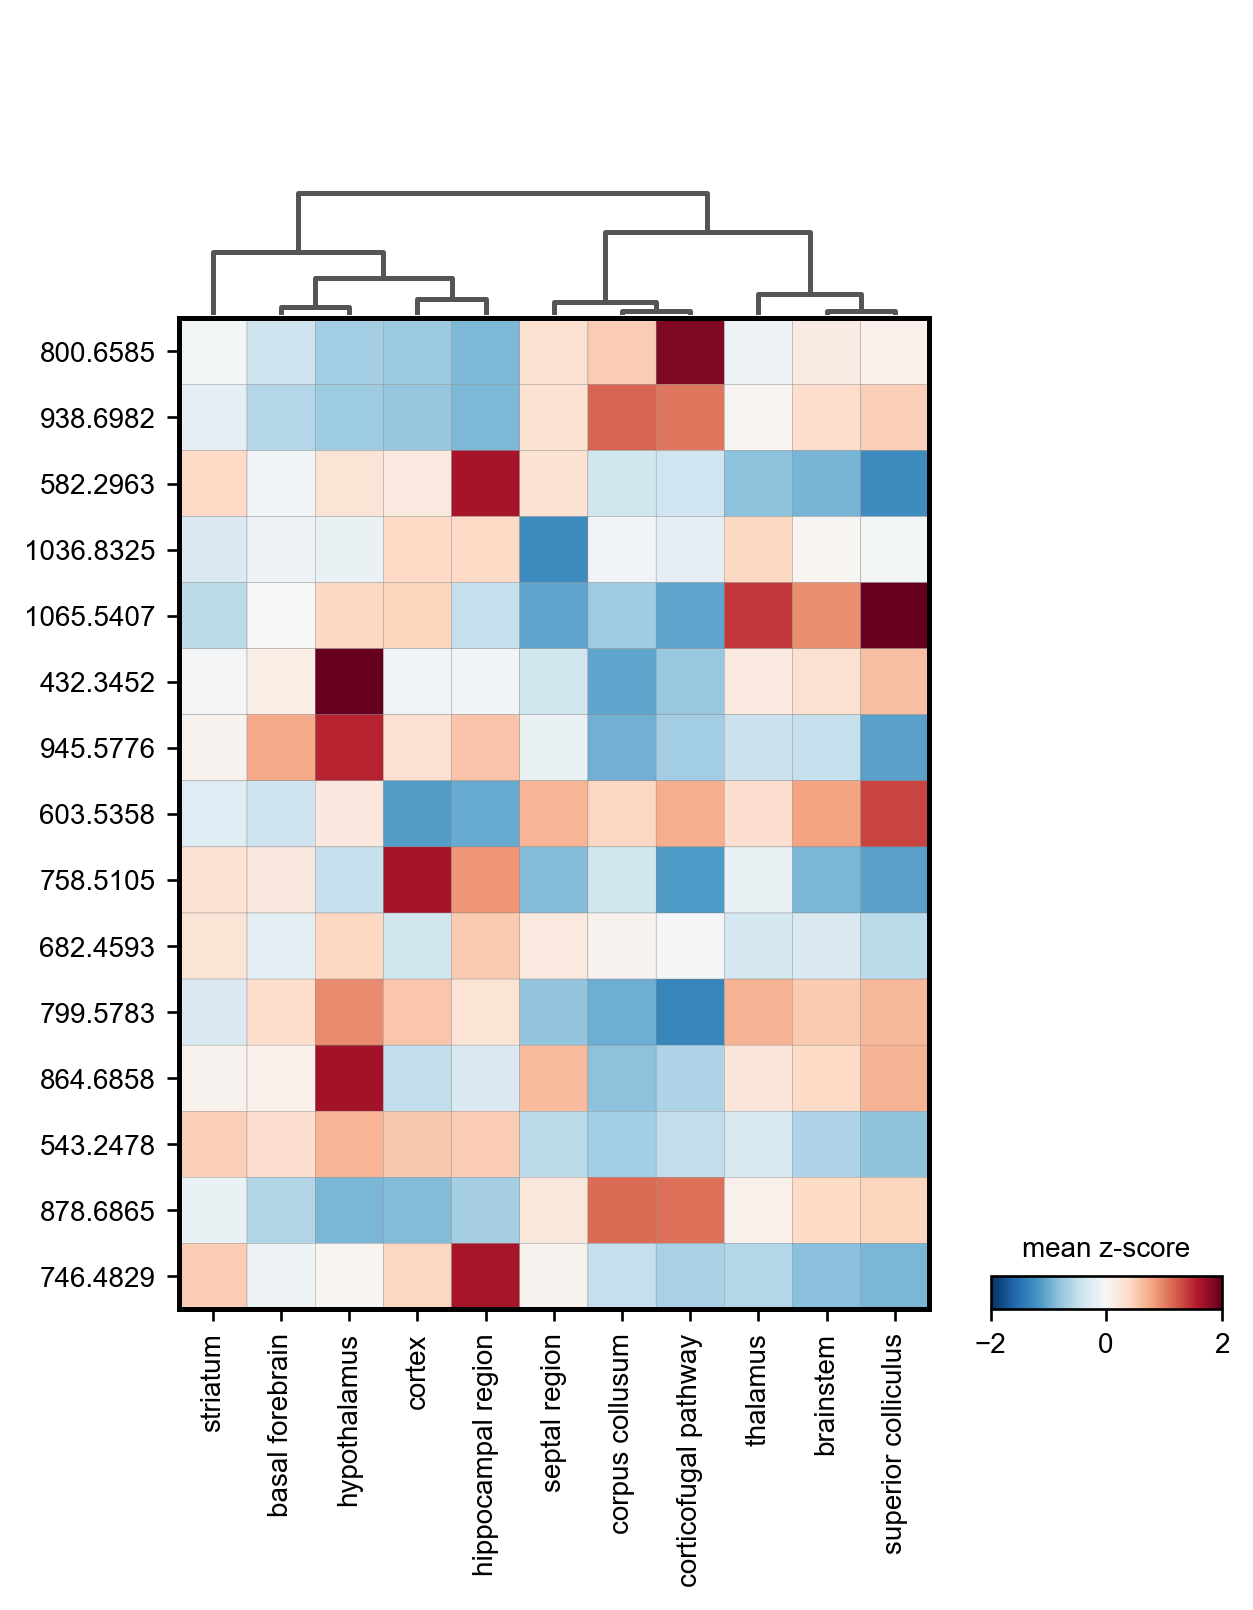

In [46]:
sc.settings.set_figure_params(dpi=120, facecolor='white',fontsize=10,figsize=(3,3))

sc.pl.matrixplot(adata, features[feature_rank[:15]].astype(str), 'region', dendrogram=True,swap_axes=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',save='3Dcoronal_regional_zscore.pdf')

In [937]:
annot_df[annot_df['Input m/z']==(reg.mzs[feature_rank[8]])]

,Input m/z,Matched m/z,Delta,Name,Formula,Ion,ppm,index
2442,787.549694,787.5507,0.0010,DG 47:12;O2,C50H75O7,[M+H]+,1.269761,456
2443,787.549694,787.5507,0.0010,TG 47:11;O,C50H75O7,[M+H]+,1.269761,456
2444,787.549694,787.5507,0.0010,TG O-47:12;O2,C50H75O7,[M+H]+,1.269761,456
2445,787.549694,787.5484,0.0013,PG 37:3,C43H80O10P,[M+H]+,1.650689,456
2446,787.549694,787.5484,0.0013,PG O-37:4;O,C43H80O10P,[M+H]+,1.650689,456
2447,787.549694,787.5483,0.0014,DG 45:9;O2,C48H76O7Na,[M+Na]+,1.777666,456
2448,787.549694,787.5483,0.0014,TG 45:8;O,C48H76O7Na,[M+Na]+,1.777666,456
2449,787.549694,787.5483,0.0014,TG O-45:9;O2,C48H76O7Na,[M+Na]+,1.777666,456
2450,787.549694,787.5460,0.0037,PG 35:0,C41H81O10PNa,[M+Na]+,4.698116,456
2451,787.549694,787.5460,0.0037,PG O-35:1;O,C41H81O10PNa,[M+Na]+,4.698116,456


<AxesSubplot:>

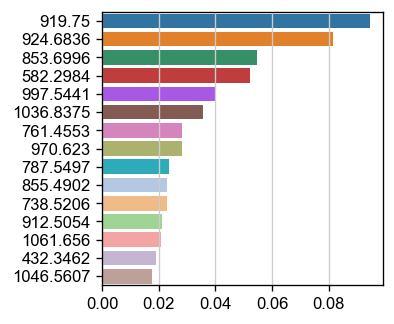

In [219]:
sns.barplot(x=model.feature_importances_[feature_rank[:15]],y=features[feature_rank[:15]],palette=)

In [278]:
annot_df['Input m/z'].unique().shape

(774,)

In [473]:
annot_df2 = []
category = []
for mz in annot_df['Input m/z'].unique():
    df = annot_df[annot_df['Input m/z']==mz]
    annot_df2.append(df[df['ppm']==df['ppm'].min()])
annot_df2 = pd.concat(annot_df2)
annot_df2 = annot_df2[annot_df2['ppm']<2]

lipid_class = [name.split(' ')[0] for name in annot_df2['Name']]
annot_df2['lipid class'] = lipid_class

In [474]:
annot_df_h = annot_df2[annot_df2['lipid class'].isin(['PS','PC','PA','PI','PE','PG','HexCer','Cer','SM','LPC','LPE','LPA','LPI'])]

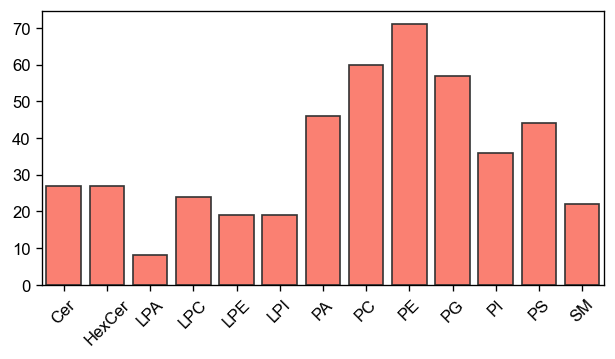

In [475]:
annot_hist = np.unique([name.split(' ')[0] for name in annot_df_h[(annot_df_h['ppm']<2)]['Name'].unique()], return_counts=True)
#annot_hist2 = np.unique([name.split(' ')[0] for name in annot_df2[annot_df2['ppm']<2]['Name'].unique()], return_counts=True)
plt.figure(figsize=(6,3))
sns.barplot(x=annot_hist[0],y=annot_hist[1],dodge=False,linewidth=1, facecolor='salmon',edgecolor=".2")
plt.xticks(rotation=45)
plt.savefig('../figures/lipidannot_hist_0.4.pdf')

<AxesSubplot:ylabel='lipid class'>

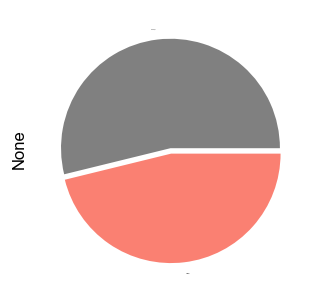

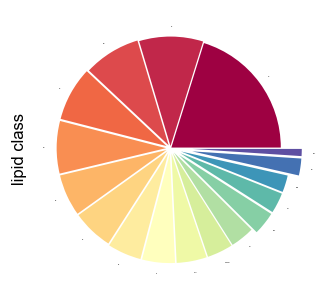

In [627]:
pd.DataFrame(np.isin(reg.mzs,annot_df2['Input m/z'].unique())).value_counts().plot(
    kind='pie', fontsize=0, colors=['grey','salmon'],explode=[0,0.05])
plt.savefig('../figures/lipidmaps_annotate.pdf')
plt.figure()
explode=[0.01,0.02,0.03,0.04,0.04,0.04,0.04,0.05,0.05,0.05,0.05,0.05,0.1,0.1,0.1,0.2,0.2]
annot_df2.loc[(annot_df2['lipid class'].isin(['TG','DG','ST','CerP','PS','PC','PA','PI','PE','PG','HexCer','Cer','SM','LPC','LPE','LPA','LPI']))]['lipid class'].value_counts().plot(
    kind='pie', fontsize=0,cmap = 'Spectral',explode=explode)

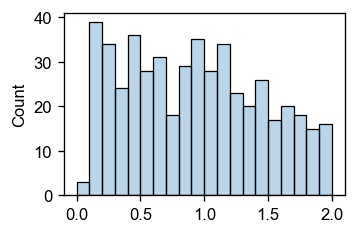

In [653]:
plt.figure(figsize=(3,2))
sns.histplot(annot_df2['ppm'].unique(),bins=20,kde=False,alpha=0.3)
plt.savefig('../figures/ppm_dist.pdf')

In [638]:
reg.mzs.shape[0]-annot_df2['Input m/z'].unique().shape[0]

590

In [382]:
average_spec_region_annot = average_spec_region[:,np.isin(reg.mzs,annot_df2['Input m/z'].unique())]

In [889]:
from scipy.stats import ranksums
treated_data = average_spec_region_annot[np.array(regions)=='thalamus']
nontreated_data = average_spec_region_annot[np.array(regions)!='thalamus']
treated_mean = treated_data.mean(0)
nontreated_mean = nontreated_data.mean(0)
log2fold = np.log2(treated_mean/nontreated_mean)
log10pvals = np.array([-np.log10(ranksums(treated_data[:,i], nontreated_data[:,i])[1]) for i in range(treated_data.shape[1])])

No handles with labels found to put in legend.


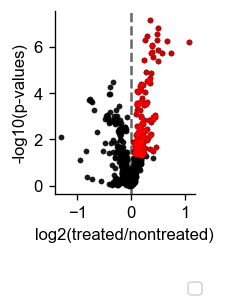

In [890]:
fig,axes = plt.subplots(1,1,figsize=(1.5,2))
df = pd.DataFrame({'log2(FC)':log2fold,'-log10(p)':log10pvals})
sns.scatterplot(x='log2(FC)',y='-log10(p)',data=df,s=10,alpha=0.9,ax=axes,color='k',edgecolor='k')
sns.scatterplot(x='log2(FC)',y='-log10(p)',data=df[(df['-log10(p)']>1.3)&(df['log2(FC)']>0)],s=10,alpha=0.7,ax=axes,color='red',edgecolor='red')

axes.axvline(0,linestyle='--',c='k',alpha=0.6)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
plt.xlabel('log2(treated/nontreated)')
plt.ylabel('-log10(p-values)')
plt.legend(loc="lower center",ncol=7,bbox_to_anchor=(1, -0.6),fontsize=10)
##plt.savefig('../figures/coronal3d_tha_volcano.pdf')

In [891]:
marker_filter = (df['-log10(p)']>1.3)&(df['log2(FC)']>0)
mz_marker = reg.mzs[np.isin(reg.mzs,annot_df2['Input m/z'].unique())][marker_filter][log10pvals[marker_filter].argsort()[::-1]]

In [895]:
annot_df2[annot_df2['Input m/z']==mz_marker[0]]
#[5,11]
#[7,0]

,Input m/z,Matched m/z,Delta,Name,Formula,Ion,ppm,index,lipid class
959,662.345086,662.3454,0.0003,ST 29:6;O2;HexNAc,C37H53NO7K,[M+K]+,0.452936,745,ST


In [596]:
marker_class = []
for mz_marker_ in mz_marker:
    marker_class.append(annot_df2[annot_df2['Input m/z']==mz_marker_]['lipid class'].values[0])

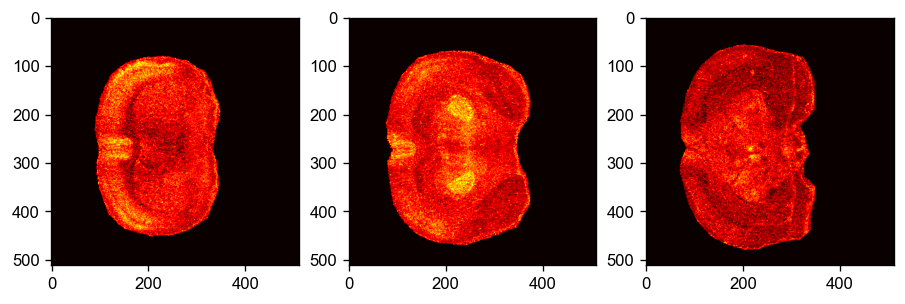

In [894]:
fig,axes=plt.subplots(1,3,figsize=(9,3))
ax = axes.ravel()
ax[0].imshow(reg.get_3DImages_transform(745,True)[3],'hot')
ax[1].imshow(reg.get_3DImages_transform(745,True)[8],'hot')
ax[2].imshow(reg.get_3DImages_transform(745,True)[18],'hot')
#fig.savefig('../figures/coronal_tha_differntial_ionimg_2.pdf')